In [150]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, r2_score




In [115]:
# pip install import-ipynb
import import_ipynb
import data_preprocessing  # Replace with the name of the notebook without `.ipynb`

u4_train_equil_turbine = data_preprocessing.u4_train_equil_turbine
u4_train_equil_pump = data_preprocessing.u4_train_equil_pump
u5_train_equil_turbine, u5_train_equil_pump, u6_train_equil_turbine, u6_train_equil_pump = data_preprocessing.u5_train_equil_turbine, data_preprocessing.u5_train_equil_pump, data_preprocessing.u6_train_equil_turbine, data_preprocessing.u6_train_equil_pump
rds_u4 = data_preprocessing.rds_u4
rds_u5 = data_preprocessing.rds_u5

In [119]:
u4_control_vars = ['tot_activepower', 'coupler_position', 'injector12_pressure',
       'injector34_pressure', 'pump_rotspeed', 'injector_01_opening',
       'injector_02_opening', 'injector_03_opening',
       'injector_04_opening', 'turbine_rotspeed']

u5_control_vars = ['tot_activepower', 'charge', 'coupler_position',
       'injector_01_opening', 'injector_02_opening',
       'injector_03_opening', 'injector_04_opening',
       'injector_05_opening', 'pump_calculated_flow',
       'pump_pressure_diff', 'pump_rotspeed', 'turbine_pressure',
       'turbine_rotspeed', 'water_primary_pump_01_opening',
       'water_primary_pump_02_opening']

natural_control_vars = ['canal_level', 'canal_tmp', 'lake_tmp', 'water_primary_cold_tmp']


In [120]:
scaler = StandardScaler()
X_train = rds_u5.data_dict["train"].measurements[u5_control_vars]
X_train_scaled = scaler.fit_transform(X_train.values)

y_train = rds_u5.data_dict["train"].measurements[['stat_magn_01_tmp']]
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)

In [152]:
# Define the model
class RegressiveNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressiveNN, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 128)  # Fully connected layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Output layer

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation for the output
        return x

# Initialize the model
input_dim = X_train.shape[1]
model = RegressiveNN(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [153]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)

epochs = 50
batch_size = 32
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 10/100, Loss: 0.7219
Epoch 20/100, Loss: 0.6270
Epoch 30/100, Loss: 0.5994
Epoch 40/100, Loss: 0.5737
Epoch 50/100, Loss: 0.5579
Epoch 60/100, Loss: 0.5504
Epoch 70/100, Loss: 0.5470
Epoch 80/100, Loss: 0.5433


KeyboardInterrupt: 

In [154]:
# Switch the model to evaluation mode
model.eval()

# Predict using the test data
with torch.no_grad():
    reconstructed = model(X_train_tensor)  # Predictions from the model

# Convert tensors back to numpy for plotting
reconstructed = reconstructed.numpy()
reconstructed = scaler_y.inverse_transform(reconstructed)
original = y_train


In [155]:
r2_score(original, reconstructed)

0.4574276804924011

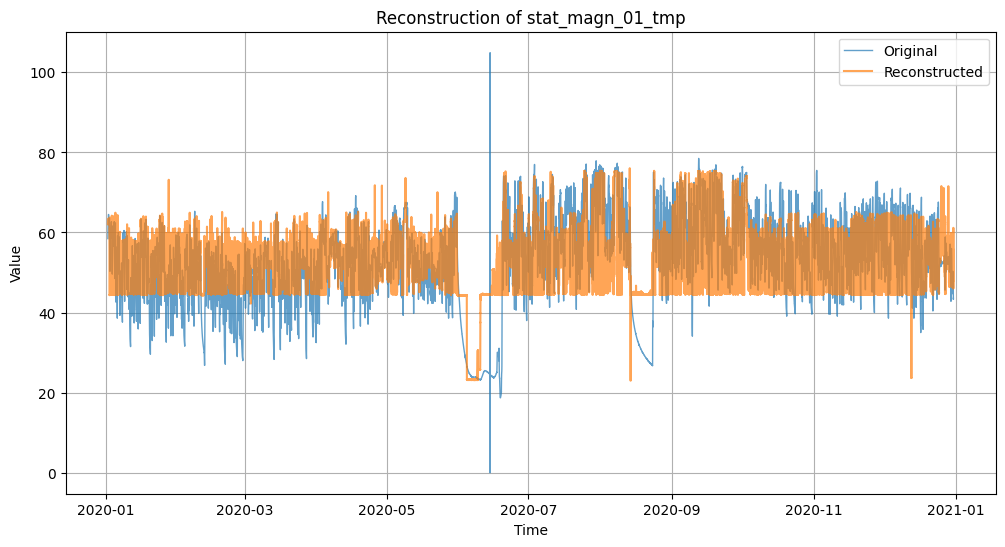

In [156]:
# Convert tensors back to numpy for plotting
time_index = X_train.index

reconstructed = reconstructed.flatten()  # Ensure predictions are 1D
# original = original.flatten()  # Ensure targets are 1D

# Plot original vs reconstructed with time as the x-axis
plt.figure(figsize=(12, 6))
plt.plot(time_index, original, label="Original", linewidth=1, alpha=0.7)
plt.plot(time_index, reconstructed, label="Reconstructed", alpha=0.7)
plt.title('Reconstruction of stat_magn_01_tmp')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


## LSTM Model

In [157]:
import torch.nn as nn

class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    
    def forward(self, x):
        # LSTM output: (batch_size, seq_length, hidden_dim)
        lstm_out, _ = self.lstm(x)
        # Take the last timestep's output
        out = lstm_out[:, -1, :]
        return self.fc(out)

# Model parameters
input_dim = X_train_scaled.shape[1]  # Number of control measurements
hidden_dim = 128  # Hidden units in LSTM
output_dim = 1  # Single target variable
num_layers = 2  # Number of LSTM layers

model = LSTMRegressor(input_dim, hidden_dim, output_dim, num_layers)


In [158]:
def create_sequences(data, target, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
        labels.append(target[i + seq_length])
    return torch.stack(sequences), torch.stack(labels)

seq_length = 10  # Example: 10 timesteps per sequence
x_seq, y_seq = create_sequences(X_train_tensor, y_train_tensor, seq_length)

# Create DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_loader = DataLoader(TimeSeriesDataset(x_seq, y_seq), batch_size=32, shuffle=True)
# test_loader = DataLoader(TimeSeriesDataset(X_train_tensor, y_train_scaled), batch_size=32, shuffle=False)


In [159]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)
X_train_tensor.shape

torch.Size([1047207, 15])

In [160]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for x_batch, y_batch in train_loader:
        # print(x_batch.shape)  # Expected: (batch_size, seq_length, input_size)
        optimizer.zero_grad()
        predictions = model(x_batch)
        # print(predictions)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/50, Loss: 0.9992
Epoch 2/50, Loss: 0.9992
Epoch 3/50, Loss: 0.9992
Epoch 4/50, Loss: 0.9992
Epoch 5/50, Loss: 0.9992
Epoch 6/50, Loss: 0.9992
Epoch 7/50, Loss: 0.9992
Epoch 8/50, Loss: 0.9992
Epoch 9/50, Loss: 0.9992
Epoch 10/50, Loss: 0.9992
Epoch 11/50, Loss: 0.9992
Epoch 12/50, Loss: 0.9992
Epoch 13/50, Loss: 0.9992
Epoch 14/50, Loss: 0.9992
Epoch 15/50, Loss: 0.9992
Epoch 16/50, Loss: 0.9992
Epoch 17/50, Loss: 0.9992
Epoch 18/50, Loss: 0.9992
Epoch 19/50, Loss: 0.9992
Epoch 20/50, Loss: 0.9992
Epoch 21/50, Loss: 0.9992
Epoch 22/50, Loss: 0.9992
Epoch 23/50, Loss: 0.9992


KeyboardInterrupt: 